# Data selection

Patients with breast cancer have been selected using following criteria:

* Patient has at least 3 ICD-9 codes from **174** group (Malignant neoplasm of female breast)
* Patient has a least 10 ICD-9 recorded before the first occurrence of 174.\* code
* Patient has a least 24 months of recorded history before the first occurrence of a 174.\* code

Control group has been selected using following criteria:

* Patient has no ICD-9 codes from 174 group (Malignant neoplasm of female breast)
* Patient is female
* Patient has a least 10 ICD-9 recorded ('distinct' by day)
* Patient has a least 24 months of recorded history

SQL queries and details can be found in ``breast_cancer/data_generation/1_sql_queries.sql``.

Breast cancer group consisted of 2,901 patients, while the control group consisted of 391,137 patients. Due to an imbalance in the number of patients in each group, only portion of controls was selected. Controls were matched to breast cancer patients to have similar range and number of codes (see ``breast_cancer/data_generation/3_control_matching.ipynb`` for details). As a result, both groups consist of 2,901 patients (5,802 total).

The final list of patients was divided into training, test and validation sets (75%/20%/5% respectively). The split was stratified (equal number of positive and negative outcomes in each group). See ``breast_cancer/data_generation/4_train_test_validation_split.ipynb for details``.

Records, including ICD-9 codes, lab orders and medications for all patients were downloaded. For breast cancer patients, only data from before the first occurrence of **174** ICD-9 code is used.

# Data processing

Both counts based and vector based datasets have variations with data from:

* 1 day before the cutoff date and older
* 1 month before the cutoff date and older
* 3 months before the cutoff date and older
* 6 months before the cutoff date and older
* 12 months before the cutoff date and older

## Counts

Firstly, medications were mapped to their corresponding ATC class (``breast_cancer/dataset_generation_counts/1_process_rxcui_atc_map``). Drugs without a mapping were dropped.  ICD-9 codes were mapped to corresponding PHEWAS codes. Counts were then calculated for PHEWAS codes, ATC classes, and lab tests. Vectors were created using ``DictVectorizer`` from scikit-learn package. As a result, datasets have from 4434 (12 months before) to 4535 (1 day before) features.

## Vectors (patient2vec based)

Vector versions of datasets were created using all trained patient2vec models. Vector lengths range from 10 to 1000.

# Classifiers

[XGBoost](https://xgboost.readthedocs.io/en/latest/) was used for classification. No parameter optimization was performed. See ``breast_cancer/classification_counts`` and ``breast_cancer/classification_vectors`` for details.


# Results

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

## Load and display results

In [2]:
counts_results = pd.read_csv('log/breast_cancer_counts_simple_xgb.log', header=None)
counts_results.columns = ['Months', 'AUC', 'Logloss']
display(HTML("<h3>Counts results</h3>"))
display(counts_results)

vectors_results = pd.read_csv('log/breast_cancer_vectors_simple_xgb.log', header=None)
vectors_results.columns = ['Model', 'Months', 'AUC', 'Logloss']
display(HTML("<h3>Vector results (head())</h3>"))
display(vectors_results.head())

,Months,AUC,Logloss
0,0,0.879080,0.467970
1,1,0.840406,0.530608
2,3,0.833302,0.544292
3,6,0.834766,0.538406
4,12,0.839967,0.527185


,Model,Months,AUC,Logloss
0,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,0,0.848208,0.618801
1,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,1,0.829011,0.629784
2,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,3,0.819921,0.653709
3,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,6,0.812069,0.688622
4,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,12,0.822811,0.652362


## Get top patient2vec models

In [3]:
def get_model_info(m_string):
    parts = m_string.split(".")[0].split("_")
    algo = parts[2]
    softmax = parts[3]
    window_size = parts[4].split("-")[1]
    emb_size = parts[5].split("-")[1]
    return "{}, {}, window: {}, embedding: {}".format(algo.upper(), softmax.upper(), window_size, emb_size)

display(HTML("<h3>Top 5 models by top score overall</h3>"))
display(vectors_results.sort_values('AUC', ascending=False)[0:5])
top_models_by_score = vectors_results.sort_values('AUC', ascending=False)[0:5]['Model'].values

display(HTML("<h3>Top 10 models by average score (avreage for all months)</h3>"))
vectors_results_model_groups = vectors_results.groupby(by='Model')
vactors_average_auc = pd.DataFrame.from_records([(model, vals['AUC'].mean()) for model, vals in vectors_results_model_groups], columns=['Model','AUC mean'])
display(vactors_average_auc.sort_values('AUC mean', ascending=False)[0:10])
top_models_by_mean = vactors_average_auc.sort_values('AUC mean', ascending=False)[0:10]['Model'].values

display(HTML("<h3>Combined list of top models</h3>"))
top_models = list(set(top_models_by_mean.tolist() + top_models_by_score.tolist()))
top_models_list_strs = ["<li>{}</li>".format(get_model_info(model)) for model in top_models]
display(HTML("<ul>{}</ul>".format("".join(top_models_list_strs))))

,Model,Months,AUC,Logloss
60,vectors_patient2vec_pvdbow_hs_win-5_emb-100.dill,0,0.868212,0.564044
10,vectors_patient2vec_pvdbow_hs_win-10_emb-500.dill,0,0.857751,0.623149
45,vectors_patient2vec_pvdbow_hs_win-50_emb-100.dill,0,0.856668,0.588994
345,vectors_patient2vec_pvdbow_hs_win-5_emb-50.dill,0,0.856410,0.578774
30,vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill,0,0.854137,0.600150


,Model,AUC mean
28,vectors_patient2vec_pvdbow_hs_win-5_emb-50.dill,0.835547
13,vectors_patient2vec_pvdbow_hs_win-30_emb-100.dill,0.834657
25,vectors_patient2vec_pvdbow_hs_win-5_emb-100.dill,0.834441
22,vectors_patient2vec_pvdbow_hs_win-50_emb-50.dill,0.831992
19,vectors_patient2vec_pvdbow_hs_win-50_emb-100.dill,0.831235
3,vectors_patient2vec_pvdbow_hs_win-10_emb-300.dill,0.828373
27,vectors_patient2vec_pvdbow_hs_win-5_emb-300.dill,0.827836
7,vectors_patient2vec_pvdbow_hs_win-20_emb-100.dill,0.827717
9,vectors_patient2vec_pvdbow_hs_win-20_emb-300.dill,0.827555
1,vectors_patient2vec_pvdbow_hs_win-10_emb-100.dill,0.826404


## Performance

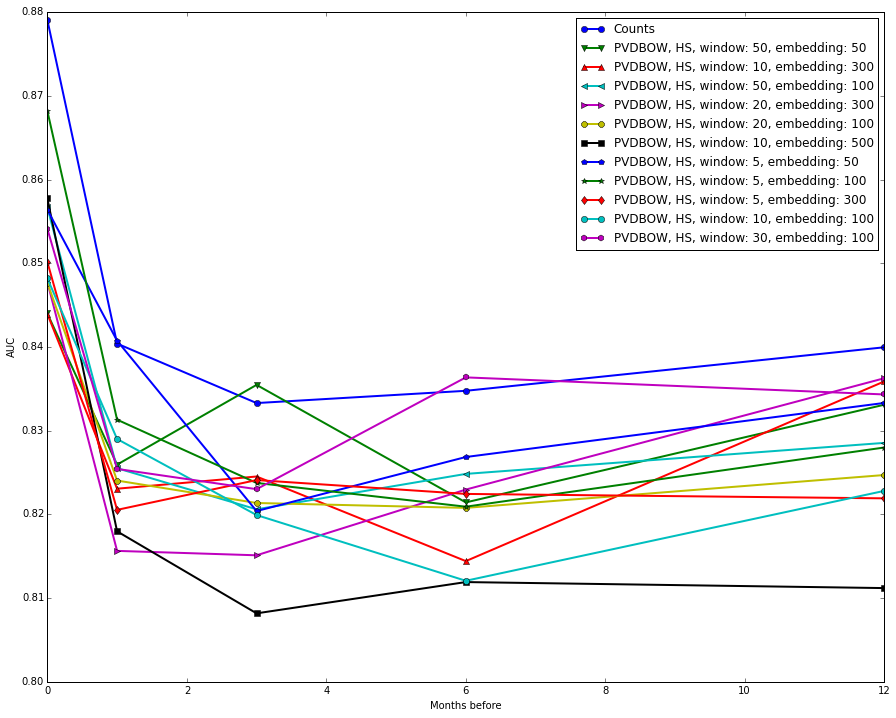

In [4]:
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
markers = "v^<>8sp*doh"

plt.plot(counts_results['Months'], counts_results['AUC'], linewidth=2.0, marker="o", label='Counts')
for i, model in enumerate(top_models):
    df = vectors_results_model_groups.get_group(model)
    plt.plot(df['Months'], df['AUC'], linewidth=2.0, marker=markers[i], label=get_model_info(model))
plt.legend(loc='upper right')
plt.xlabel('Months before')
plt.ylabel('AUC')
plt.show()

## Learning curves

/Users/jacek/.pyenv/versions/3.5.0/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


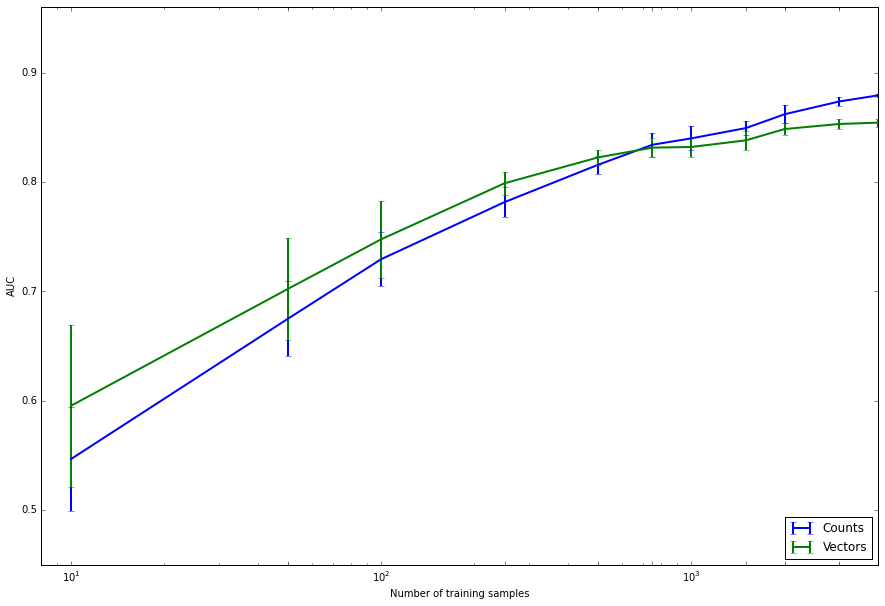

In [5]:
# Counts
lc_counts_df = pd.read_csv('log/breast_cancer_counts_simple_learning_curves.log', header=None)
lc_counts_df.columns = ['samples', 'auc', 'logloss']
lc_counts_sample_groups = lc_counts_df.groupby(by='samples')

samples = []
lc_counts_means = []
lc_counts_stds = []

for g, g_df in lc_counts_sample_groups:
    samples.append(g)
    lc_counts_means.append(g_df['auc'].mean())
    lc_counts_stds.append(g_df['auc'].std())
    
# Vectors

# Vector performace based on patient2vec : PVDBOW, HS, windows size 20, embedding size 100
lc_vectors_df = pd.read_csv('log/breast_cancer_vectors_simple_learning_curves.log', header=None)
lc_vectors_df.columns = ['samples', 'auc', 'logloss']
lc_vectors_sample_groups = lc_vectors_df.groupby(by='samples')

lc_vectors_means = []
lc_vectors_stds = []

for g, g_df in lc_vectors_sample_groups:
    lc_vectors_means.append(g_df['auc'].mean())
    lc_vectors_stds.append(g_df['auc'].std())
    
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

plt.errorbar(samples, lc_counts_means, yerr=lc_counts_stds, label='Counts', linewidth=2.0)
plt.errorbar(samples, lc_vectors_means, yerr=lc_vectors_stds, label='Vectors', linewidth=2.0)
plt.legend(loc='lower right')
plt.xlim((8,2500))
plt.xlabel('Number of training samples')
plt.xscale('log')
plt.xticks(samples)
plt.ylim((0.45,0.96))
plt.ylabel('AUC')
plt.show()

# Discussion

TODO